# 환경 설정
런타임 - 런타임 유형 변경 - GPU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Colab 파이썬 버전 확인
import sys
print(sys.version)

# 필요한 라이브러리 설치
!pip install mxnet                    # mxnet: 딥러닝 프레임워크
!pip install gluonnlp pandas tqdm     # gluonnlp: 오픈소스 딥러닝 기반의 자연어 처리 툴킷
!pip install sentencepiece            # sentencepiece: pre-tokenization을 필요로 하지 않는 tokenizer
!pip install transformers             # transformer
!pip install torch                    # torch
!pip install kss                      # kss

# https://github.com/SKTBrain/KoBERT 의 파일을 Colab으로 다운로드
!pip install 'git+https://git@github.com/SKTBrain/KoBERT.git@master'
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp310-cp310-linux_x86_64.whl size=661777 sha256=f20ed808d2c5005d620b7d332ba255639fc8cc582cf6e50a0ea26e0f65bc491c
  Stored in directory: /root/.cache/pip/wheels/1a/1e/0d/99f55911d90f2b95b9f7c176d5813ef3622894a4b30fde6bd3
Successfully built gluonnlp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 3.6 MB/s eta 0:00:0

In [ ]:
# 필요한 라이브러리 import
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import pandas as pd

# Hugging Face를 통한 모델 및 토크나이저 Import
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

import os
import re

# GPU 사용 시
device = torch.device("cuda:0")

In [ ]:
# 데이터 준비

df = pd.read_csv('/content/drive/MyDrive/ICR_project/네이버뉴스 텍스트마이닝/ESG_result/sentences_DB_중복제거.csv', encoding='utf-8-sig')

df['종목코드']  = df['종목코드'].astype(str).str.zfill(6)

df['작성날짜'] = pd.to_datetime(df['작성날짜'])
df['날짜'] = pd.to_datetime(df['날짜'])

df_E = df[df['구분']=='E']
df_S = df[df['구분']=='S']
df_G = df[df['구분']=='G']

# E

## 모델링

In [ ]:
# 학습데이터 불러오기
import pandas as pd
E_sentences = pd.read_csv('/content/drive/MyDrive/ICR_project/네이버뉴스 텍스트마이닝/ESG_result/E_sentences.csv', encoding='utf-8-sig')

E_sentences = E_sentences.dropna()
E_sentences['score'] = E_sentences['score'].astype(int)
E_sentences = E_sentences[E_sentences['score'] != 9]
print(E_sentences['score'].value_counts())

# data_list 생성 (tensor 형식)
data_list = []
for review, label in zip(E_sentences['sentence'], E_sentences['score']):
    data = []
    data.append(review)
    data.append(label)
    data_list.append(data)

# train, test 데이터셋으로 나눔
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(data_list, test_size = 0.2, shuffle = True, random_state = 32, stratify=E_sentences['score'])
print(len(dataset_train), len(dataset_test))

2    1408
1      76
0      70
Name: score, dtype: int64
1243 311


In [ ]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [ ]:
# PyTorch의 Dataset 클래스를 상속받아 BERT 모델을 학습하기 위한 데이터셋을 생성하는 클래스인 BERTDataset을 정의
# 이 클래스는 데이터셋을 BERT 모델의 입력 형식으로 변환하는 역할

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

BERTDataset 클래스의 파라미터  
* dataset: BERT 모델 학습에 사용될 데이터셋
*  sent_idx: 문장(텍스트)이 있는 열의 인덱스입니다.
* label_idx: 레이블이 있는 열의 인덱스입니다.
* bert_tokenizer: BERT 토크나이저입니다.
* vocab: 어휘 사전입니다.
* max_len: 최대 시퀀스 길이입니다.
* pad: 패딩 여부를 나타내는 불리언 값입니다.
* pair: 문장 페어(pair) 여부를 나타내는 불리언 값입니다.

BERTDataset 클래스의 메서드
* __init__(self, ...): 클래스의 초기화 메서드로, 주어진 매개변수들을 사용하여 데이터셋을 BERT 모델의 입력 형식으로 변환할 수 있는 변환 객체를 생성합니다.
* __getitem__(self, i): 주어진 인덱스 i에 해당하는 데이터셋의 항목을 반환. 반환되는 항목은 BERT 모델의 입력으로 사용될 수 있도록 변환된 문장과 해당 문장의 레이블
* __len__(self): 데이터셋의 전체 길이를 반환

In [ ]:
# 하이퍼파라미터
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

tok = tokenizer.tokenize

train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
test = BERTDataset(dataset_test, 0, 1, tok, vocab, max_len, True, False)

train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=2)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert, hidden_size=768, num_classes=3, dr_rate=None, params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
E_model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in E_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in E_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    E_model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = E_model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(E_model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    E_model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = E_model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

<ipython-input-13-94a40c53a99a>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/20 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.2234262228012085 train acc 0.203125
epoch 1 train acc 0.7543113425925926


<ipython-input-13-94a40c53a99a>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 1 test acc 0.9073295454545456


  0%|          | 0/20 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.3366502821445465 train acc 0.921875
epoch 2 train acc 0.9035300925925925


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 2 test acc 0.9073295454545456


  0%|          | 0/20 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.36143240332603455 train acc 0.921875
epoch 3 train acc 0.9171006944444444


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 3 test acc 0.9193181818181818


  0%|          | 0/20 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.23487630486488342 train acc 0.9375
epoch 4 train acc 0.9256944444444445


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 4 test acc 0.9198295454545455


  0%|          | 0/20 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.21399514377117157 train acc 0.9375
epoch 5 train acc 0.9353587962962964


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 5 test acc 0.9229545454545456


## Prediction

In [ ]:
# 모델 저장
torch.save(E_model, "/content/drive/MyDrive/ICR_project/네이버뉴스 텍스트마이닝/ESG_result/E_model.pt")

In [ ]:
def E_score_predict(predict_sentence):
    data = [predict_sentence, '0']
    dataset_another = [data]
    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=2)

    E_model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = E_model(token_ids, valid_length, segment_ids)
        test_eval=[]
        for i in out:
          logits=i
          logits = logits.detach().cpu().numpy()
          test_eval.append(logits)
        probabilities = F.softmax(torch.tensor(test_eval[0]), dim=0).numpy()
        # print(">> 입력하신 내용에 대한 확률 값은:", probabilities)


    return probabilities[0], probabilities[1], probabilities[2]

In [ ]:
E_score_predict('환경을 보호했다')

(0.25879347, 0.2104407, 0.5307659)

## 문장별 점수 산출

In [ ]:
E_score = df_E['문장'].copy().apply(E_score_predict).apply(lambda x: x[2])

df_E['E_score'] = E_score
df_E.to_csv('/content/drive/MyDrive/ICR_project/네이버뉴스 텍스트마이닝/ESG_result/E_score.csv', encoding='utf-8-sig', index=False)
df_E

<ipython-input-18-71825df39d40>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_E['E_score'] = E_score


,ID,기업명,종목명,종목코드,작성날짜,날짜,연분기,매체,제목,url,문장,구분,E_score
14,C001880202001,DL건설,DL건설,001880,2020-02-21,2020-01-01,202001,연합뉴스,"수자공, 시화호 위에 '대관람차' 추진…""랜드마크 기대""",https://n.news.naver.com/mnews/article/001/001...,"2024년말 완공 전망…환경단체 ""철새 이동 방해…반대운동 벌일 것""(안산=연합뉴스...",E,0.660817
15,C001880202001,DL건설,DL건설,001880,2020-02-21,2020-01-01,202001,연합뉴스,"수자공, 시화호 위에 '대관람차' 추진…""랜드마크 기대""",https://n.news.naver.com/mnews/article/001/001...,수자원공사는 이 시설이 완공되면 연간 350여만명의 관람객이 찾는 영국의 대관람차 ...,E,0.794344
16,C001880202001,DL건설,DL건설,001880,2020-02-21,2020-01-01,202001,연합뉴스,"수자공, 시화호 위에 '대관람차' 추진…""랜드마크 기대""",https://n.news.naver.com/mnews/article/001/001...,시화호 횡단 송산그린시티-시화MTV 연결도로 조감도 21일 수자원공사에 따르면...,E,0.888886
17,C001880202001,DL건설,DL건설,001880,2020-02-21,2020-01-01,202001,연합뉴스,"수자공, 시화호 위에 '대관람차' 추진…""랜드마크 기대""",https://n.news.naver.com/mnews/article/001/001...,시화호 횡단 송산그린시티-시화MTV 연결도로 상 대관람차 조감도 수자원공사는 ...,E,0.795669
18,C001880202001,DL건설,DL건설,001880,2020-02-21,2020-01-01,202001,연합뉴스,"수자공, 시화호 위에 '대관람차' 추진…""랜드마크 기대""",https://n.news.naver.com/mnews/article/001/001...,시화호 횡단 송산그린시티-시화MTV 연결도로 위치도 및 조감도 수자원공사 시화...,E,0.772423
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66621,C000720202303,현대건설,현대건설,000720,2023-09-20,2023-07-01,202303,아시아경제,수도권 청약시장 회복세에 합리적인 분양가 등 장점 두루 갖춘 ‘힐스테이트 더웨이브시티’,https://n.news.naver.com/mnews/article/277/000...,시화MTV는 한국수자원공사가 3조6003억 원의 예산을 들여 지식기반 산업 중심의 ...,E,0.876304
66622,C000720202303,현대건설,현대건설,000720,2023-09-22,2023-07-01,202303,한국일보,미·캐나다와 핵심광물 공급망 확보 협업 강화,https://n.news.naver.com/mnews/article/469/000...,K-SURE는 미국 DOE와 재생에너지 등 녹색산업에서 우리 기업의 시장진출 기회를...,E,0.968612
66623,C000720202303,현대건설,현대건설,000720,2023-09-22,2023-07-01,202303,한국일보,미·캐나다와 핵심광물 공급망 확보 협업 강화,https://n.news.naver.com/mnews/article/469/000...,"캐나다 EDC와는 북미·인도태평양 제3국을 아우르는 지역의 핵심광물, SMR(소형모...",E,0.970227
66624,C000720202303,현대건설,현대건설,000720,2023-09-22,2023-07-01,202303,한국일보,미·캐나다와 핵심광물 공급망 확보 협업 강화,https://n.news.naver.com/mnews/article/469/000...,지난 4월에는 미국 원자력기업 홀텍·현대건설과 차세대 원전산업 육성을 위한 협약도 ...,E,0.965169


<Axes: >

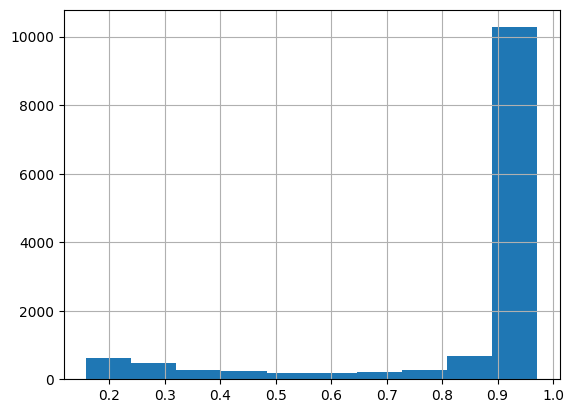

In [ ]:
df_E['E_score'].hist()

# S

## 모델링

In [ ]:
# 학습데이터 불러오기
import pandas as pd
S_sentences = pd.read_csv('/content/drive/MyDrive/ICR_project/네이버뉴스 텍스트마이닝/ESG_result/S_sentences.csv', encoding='utf-8-sig')

S_sentences = S_sentences.dropna()
S_sentences['score'] = S_sentences['score'].astype(int)
S_sentences = S_sentences[S_sentences['score'] != 9]
print(S_sentences['score'].value_counts())

# data_list 생성 (tensor 형식)
data_list = []
for review, label in zip(S_sentences['sentence'], S_sentences['score']):
    data = []
    data.append(review)
    data.append(label)
    data_list.append(data)

# train, test 데이터셋으로 나눔
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(data_list, test_size = 0.2, shuffle = True, random_state = 32, stratify=S_sentences['score'])
print(len(dataset_train), len(dataset_test))

1    4912
2    3504
0    2955
Name: score, dtype: int64
9096 2275


In [ ]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
# PyTorch의 Dataset 클래스를 상속받아 BERT 모델을 학습하기 위한 데이터셋을 생성하는 클래스인 BERTDataset을 정의
# 이 클래스는 데이터셋을 BERT 모델의 입력 형식으로 변환하는 역할

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

BERTDataset 클래스의 파라미터  
* dataset: BERT 모델 학습에 사용될 데이터셋
*  sent_idx: 문장(텍스트)이 있는 열의 인덱스입니다.
* label_idx: 레이블이 있는 열의 인덱스입니다.
* bert_tokenizer: BERT 토크나이저입니다.
* vocab: 어휘 사전입니다.
* max_len: 최대 시퀀스 길이입니다.
* pad: 패딩 여부를 나타내는 불리언 값입니다.
* pair: 문장 페어(pair) 여부를 나타내는 불리언 값입니다.

BERTDataset 클래스의 메서드
* __init__(self, ...): 클래스의 초기화 메서드로, 주어진 매개변수들을 사용하여 데이터셋을 BERT 모델의 입력 형식으로 변환할 수 있는 변환 객체를 생성합니다.
* __getitem__(self, i): 주어진 인덱스 i에 해당하는 데이터셋의 항목을 반환. 반환되는 항목은 BERT 모델의 입력으로 사용될 수 있도록 변환된 문장과 해당 문장의 레이블
* __len__(self): 데이터셋의 전체 길이를 반환

In [ ]:
# 하이퍼파라미터
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

tok = tokenizer.tokenize

train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
test = BERTDataset(dataset_test, 0, 1, tok, vocab, max_len, True, False)

train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=2)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert, hidden_size=768, num_classes=3, dr_rate=None, params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
S_model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in S_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in S_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    S_model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = S_model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(S_model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    S_model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = S_model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

<ipython-input-15-008390374b25>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/143 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.1915918588638306 train acc 0.375
epoch 1 train acc 0.7880244755244755


<ipython-input-15-008390374b25>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/36 [00:00<?, ?it/s]

epoch 1 test acc 0.96875


  0%|          | 0/143 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.20091335475444794 train acc 0.953125
epoch 2 train acc 0.9722465034965035


  0%|          | 0/36 [00:00<?, ?it/s]

epoch 2 test acc 0.9739583333333334


  0%|          | 0/143 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.10022157430648804 train acc 0.96875
epoch 3 train acc 0.9802229020979021


  0%|          | 0/36 [00:00<?, ?it/s]

epoch 3 test acc 0.9778645833333334


  0%|          | 0/143 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.10217443108558655 train acc 0.96875
epoch 4 train acc 0.9874344405594405


  0%|          | 0/36 [00:00<?, ?it/s]

epoch 4 test acc 0.9761284722222222


  0%|          | 0/143 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.08518124371767044 train acc 0.96875
epoch 5 train acc 0.9925699300699301


  0%|          | 0/36 [00:00<?, ?it/s]

epoch 5 test acc 0.9782986111111112


## Prediction

In [ ]:
# 모델 저장
torch.save(S_model, "/content/drive/MyDrive/ICR_project/네이버뉴스 텍스트마이닝/ESG_result/S_model.pt")

In [ ]:
def S_score_predict(predict_sentence):
    data = [predict_sentence, '0']
    dataset_another = [data]
    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=2)

    S_model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = S_model(token_ids, valid_length, segment_ids)
        test_eval=[]
        for i in out:
          logits=i
          logits = logits.detach().cpu().numpy()
          test_eval.append(logits)
        probabilities = F.softmax(torch.tensor(test_eval[0]), dim=0).numpy()
        # print(">> 입력하신 내용에 대한 확률 값은:", probabilities)


    return probabilities[0], probabilities[1], probabilities[2]

In [ ]:
S_score_predict('환경을 보호했다')

(0.0046917936, 0.9942754, 0.0010328479)

## 문장별 점수 산출

In [ ]:
S_score = df_S['sentence'].copy().apply(S_score_predict).apply(lambda x: x[2])

df_S['S_score'] = S_score
df_S.to_csv('/content/drive/MyDrive/ICR_project/네이버뉴스 텍스트마이닝/ESG_result/S_score.csv', encoding='utf-8-sig', index=False)
df_S

<ipython-input-53-fad2bfc7e62e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_S['S_score'] = S_score


,company,title,date,media,content,url,content2,종목명,종목코드,date2,quarter,ID,sentence,aspect,S_score
20,DL이앤씨,"82주년 맞이하는 DL, 새로운 사명과 CI 공개",2020-12-29,스타뉴스,"[스타뉴스 채준 기자] /사진제공=dl새 출발하는 DL, 닻 올렸다!!! 내년 1월...",https://n.news.naver.com/mnews/article/108/000...,"새 출발하는 DL, 닻 올렸다!!! 내년 1월 1일 공식 출범하는 대림이 그룹 명...",DL이앤씨,375500,2020-10-01,202004,375500202004,스타뉴스 핫이슈 생생 스타 현장 스타 인기영상,S,0.000769
27,DL이앤씨,"82주년 맞이하는 DL, 새로운 사명과 CI 공개",2020-12-29,스타뉴스,"[스타뉴스 채준 기자] /사진제공=dl새 출발하는 DL, 닻 올렸다!!! 내년 1월...",https://n.news.naver.com/mnews/article/108/000...,"새 출발하는 DL, 닻 올렸다!!! 내년 1월 1일 공식 출범하는 대림이 그룹 명...",DL이앤씨,375500,2020-10-01,202004,375500202004,스타뉴스 핫이슈 생생 스타 현장 스타 인기영상,S,0.000769
34,DL이앤씨,"82주년 맞이하는 DL, 새로운 사명과 CI 공개",2020-12-29,스타뉴스,"[스타뉴스 채준 기자] /사진제공=dl새 출발하는 DL, 닻 올렸다!!! 내년 1월...",https://n.news.naver.com/mnews/article/108/000...,"새 출발하는 DL, 닻 올렸다!!! 내년 1월 1일 공식 출범하는 대림이 그룹 명...",DL이앤씨,375500,2020-10-01,202004,375500202004,스타뉴스 핫이슈 생생 스타 현장 스타 인기영상,S,0.000769
41,DL이앤씨,"82주년 맞이하는 DL, 새로운 사명과 CI 공개",2020-12-29,스타뉴스,"[스타뉴스 채준 기자] /사진제공=dl새 출발하는 DL, 닻 올렸다!!! 내년 1월...",https://n.news.naver.com/mnews/article/108/000...,"새 출발하는 DL, 닻 올렸다!!! 내년 1월 1일 공식 출범하는 대림이 그룹 명...",DL이앤씨,375500,2020-10-01,202004,375500202004,스타뉴스 핫이슈 생생 스타 현장 스타 인기영상,S,0.000769
48,DL이앤씨,"82주년 맞이하는 DL, 새로운 사명과 CI 공개",2020-12-29,스타뉴스,"[스타뉴스 채준 기자] /사진제공=dl새 출발하는 DL, 닻 올렸다!!! 내년 1월...",https://n.news.naver.com/mnews/article/108/000...,"새 출발하는 DL, 닻 올렸다!!! 내년 1월 1일 공식 출범하는 대림이 그룹 명...",DL이앤씨,375500,2020-10-01,202004,375500202004,스타뉴스 핫이슈 생생 스타 현장 스타 인기영상,S,0.000769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63421,현대건설,"건설기계 회사의 눈길끄는 도전...현대제뉴인, ""2050 탄소중립 달성하겠다"" [E...",2022-12-29,한국일보,"현대제뉴인·건설기계·두산인프라코어 '통합 ESG' 경영체제 구축탄소감축 비율, 20...",https://n.news.naver.com/mnews/article/469/000...,"현대제뉴인·건설기계·두산인프라코어 '통합 ESG' 경영체제 구축탄소감축 비율, 20...",현대건설,000720,2022-10-01,202204,000720202204,"조영철(앞줄 왼쪽) 현대제뉴인 대표이사 사장이 협력사를 방문, ESG 현장 점검을 ...",S,0.999120
63442,현대건설,"‘건설 맏형’ 현대건설, 올해 도시정비 9조 수주…4년째 1위",2022-12-30,이코노미스트,"총 14개 시공권 확보해 건설업계 최대 실적 갱신2위 GS건설 7조, 3위 대우건설...",https://n.news.naver.com/mnews/article/243/000...,"총 14개 시공권 확보해 건설업계 최대 실적 갱신2위 GS건설 7조, 3위 대우건설...",현대건설,000720,2022-10-01,202204,000720202204,이 밖에도 총 6곳의 현장이 착공에 들어갔다.,S,0.000518
63443,현대건설,"‘건설 맏형’ 현대건설, 올해 도시정비 9조 수주…4년째 1위",2022-12-30,이코노미스트,"총 14개 시공권 확보해 건설업계 최대 실적 갱신2위 GS건설 7조, 3위 대우건설...",https://n.news.naver.com/mnews/article/243/000...,"총 14개 시공권 확보해 건설업계 최대 실적 갱신2위 GS건설 7조, 3위 대우건설...",현대건설,000720,2022-10-01,202204,000720202204,현대건설이 단독 시공을 맡은 착공 현장은 방배5구역 의정부 금오생활권1구역 대...,S,0.000487
63445,현대건설,"[부동산 단신] 현대건설, 임직원 급여 끝전 모아 공동모금회에 기탁 외",2022-12-30,세계일보,"현대건설, 임직원 급여 끝전 모아 공동모금회에 기탁 현대건설은 지난해 1...",https://n.news.naver.com/mnews/article/022/000...,"현대건설, 임직원 급여 끝전 모아 공동모금회에 기탁 현대건설은 지난해 1...",현대건설,000720,2022-10-01,202204,000720202204,전달식(사진)에는 김기년 현대건설 노동조합 사무국장과 황인식 사회복지공동모금회 사무...,S,0.000738


# G

## 모델링

In [ ]:
# 학습데이터 불러오기
import pandas as pd
G_sentences = pd.read_csv('/content/drive/MyDrive/ICR_project/네이버뉴스 텍스트마이닝/ESG_result/G_sentences.csv', encoding='utf-8-sig')

G_sentences = G_sentences.dropna()
G_sentences['score'] = G_sentences['score'].astype(int)
G_sentences = G_sentences[G_sentences['score'] != 9]
print(G_sentences['score'].value_counts())

# data_list 생성 (tensor 형식)
data_list = []
for review, label in zip(G_sentences['sentence'], G_sentences['score']):
    data = []
    data.append(review)
    data.append(label)
    data_list.append(data)

# train, test 데이터셋으로 나눔
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(data_list, test_size = 0.2, shuffle = True, random_state = 32, stratify=G_sentences['score'])
print(len(dataset_train), len(dataset_test))

FileNotFoundError: ignored

In [ ]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

In [ ]:
# PyTorch의 Dataset 클래스를 상속받아 BERT 모델을 학습하기 위한 데이터셋을 생성하는 클래스인 BERTDataset을 정의
# 이 클래스는 데이터셋을 BERT 모델의 입력 형식으로 변환하는 역할

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

BERTDataset 클래스의 파라미터  
* dataset: BERT 모델 학습에 사용될 데이터셋
*  sent_idx: 문장(텍스트)이 있는 열의 인덱스입니다.
* label_idx: 레이블이 있는 열의 인덱스입니다.
* bert_tokenizer: BERT 토크나이저입니다.
* vocab: 어휘 사전입니다.
* max_len: 최대 시퀀스 길이입니다.
* pad: 패딩 여부를 나타내는 불리언 값입니다.
* pair: 문장 페어(pair) 여부를 나타내는 불리언 값입니다.

BERTDataset 클래스의 메서드
* __init__(self, ...): 클래스의 초기화 메서드로, 주어진 매개변수들을 사용하여 데이터셋을 BERT 모델의 입력 형식으로 변환할 수 있는 변환 객체를 생성합니다.
* __getitem__(self, i): 주어진 인덱스 i에 해당하는 데이터셋의 항목을 반환. 반환되는 항목은 BERT 모델의 입력으로 사용될 수 있도록 변환된 문장과 해당 문장의 레이블
* __len__(self): 데이터셋의 전체 길이를 반환

In [ ]:
# 하이퍼파라미터
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

tok = tokenizer.tokenize

train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
test = BERTDataset(dataset_test, 0, 1, tok, vocab, max_len, True, False)

train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=2)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert, hidden_size=768, num_classes=3, dr_rate=None, params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
G_model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in G_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in G_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)


In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    G_model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = G_model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(G_model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    G_model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = G_model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

## Prediction

In [ ]:
# 모델 저장
torch.save(G_model, "/content/drive/MyDrive/ICR_project/네이버뉴스 텍스트마이닝/ESG_result/G_model.pt")

In [ ]:
def G_score_predict(predict_sentence):
    data = [predict_sentence, '0']
    dataset_another = [data]
    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=2)

    G_model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = G_model(token_ids, valid_length, segment_ids)
        test_eval=[]
        for i in out:
          logits=i
          logits = logits.detach().cpu().numpy()
          test_eval.append(logits)
        probabilities = F.softmax(torch.tensor(test_eval[0]), dim=0).numpy()
        # print(">> 입력하신 내용에 대한 확률 값은:", probabilities)


    return probabilities[0], probabilities[1], probabilities[2]

In [ ]:
G_score_predict('환경을 보호했다')

## 문장별 점수 산출

In [ ]:
G_score = df_G['sentence'].copy().apply(G_score_predict).apply(lambda x: x[2])

df_G['G_score'] = G_score
df_G.to_csv('/content/drive/MyDrive/ICR_project/네이버뉴스 텍스트마이닝/ESG_result/G_score.csv', encoding='utf-8-sig', index=False)
df_G